일단은...01/29 에

관련 기사, 논문, 데이터 찾아보기

동탄 언제갈지 정하기

하기로 했습니다

화면도 잘 보이시죠?

주제 : [음주운전+교통사고 발생건수 / 시간 + 요일 + 지역 + 경찰 수] 을 통해서 발생지역 예측 OR 발생 시간대 & 요일 예측해서 인력배치를 얼마나 할지

통계팀
    - 스터디~
    - 주소 [구]를 추출, // 구별 사건현황 시각화 (401+406)
                                (발생건수, 요일별 발생, 지역별 발생)
                       - 토요일 밤 10시 회의에 말씀드리겠습니다, 성길 -

시각화팀
 - 날씨(+ 가시거리) 변수 추가하자
 - 앙상블, 랜덤포레스트, m?ap? => 모델마다 중요한 변수가 다 다르니 사용은 니 맘이다
 - 경찰서 별 긴급신고가 몇 개나 있었는지/ 긴급도에 따른 인력 투입
     - 시간대를 범주화해서 데이터에 긴급도 가중치? 가산점? 을 줌


변수 추가할거(주의할 점 : !충남, 대전, 세종 지역의 자료여야 함!)
  - 날씨, 구(주소), 경찰관 수, 단속장비 유무, 신호등 개수, 사고당사자의 총 운전거리,  횡단보도 개수, 유동인구 수, 총 인구수, 동승자 수, 운전면허 소지자의 나이, 음주운전 단속 빈도
     
========================================================================

업무분담 01/30 밤 10시에 시각화 및 자료 공유

- 해당범죄가 몇 건이나 발생했는가? : 성길 / 날씨, 구(주소), 경찰관 수

- 가장 많이 발생한 시간은 언제인가? : 동현 / 단속장비 유무, 신호등 개수, 사고당사자의 총 운전거리

- 요일과 관련이 있는가? : 나은 / 횡단보도 개수, 유동인구 수, 총 인구수

- 가장 많이 발생한 지역은 어디인가? : 하경 / 동승자 수, 운전면허 소지자의 나이, 음주운전 단속 빈도


### 그렇다면 기본틀을 어떻게 잡아야할까?
- 1. 지역선택 :(충남, 대전, 세종)
- 2. 범죄선택 : 음주운전+교통사고

- 3. 사건현황 분석(해당범죄가 몇 건이나 발생했는가,가장 많이 발생한 시간은 언제인가, 요일과 관련이 있는가, 가장 많이 발생한 지역은 어디인가 ...)

- 4. 알고리즘 제작(후에 예측값 도출)
- 5. 예측률과 이에 따른 기대효과

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77077 entries, 0 to 77076
Data columns (total 10 columns):
 #Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RECV_DEPT_NM   77077 non-null  object 
 1   RECV_CPLT_DM   77077 non-null  object 
 2   NPA_CL         77077 non-null  int64  
 3   EVT_STAT_CD    77077 non-null  int64  
 4   EVT_CL_CD      77077 non-null  int64  
 5   RPTER_SEX      74658 non-null  float64
 6   HPPN_PNU_ADDR  47805 non-null  object 
 7   HPPN_X         60313 non-null  float64
 8   HPPN_Y         60313 non-null  float64
 9   SME_EVT_YN     13442 non-null  object 

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\\Windows\\Fonts\\malgun.ttf").get_name()
plt.rc("font", family=font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

%config InlineBackend.figure_format = 'retina' # 폰트를 선명하게~

C:\Users\minir\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
kp20=pd.read_csv("C:\\Users\\minir\\OneDrive\\바탕 화면\\지치안\\data\\KP2020.csv")

kp21=pd.read_csv("C:\\Users\\minir\\OneDrive\\바탕 화면\\지치안\\data\\KP2021.csv")

In [3]:
kp20.rename(columns={"RECV_DEPT_NM":"접수부서코드","RECV_CPLT_DM":"접수완료일시", "NPA_CL":"경찰청구분", "EVT_STAT_CD":"사건상태코드","EVT_CL_CD":"사건종별코드","RPTER_SEX":"신고성별","HPPN_PNU_ADDR":"발생지점","HPPN_X":"발생좌표x","HPPN_Y":"발생좌표y","SME_EVT_YN":"동일사건여부"}, inplace=True)
kp21.rename(columns={"RECV_DEPT_NM":"접수부서코드","RECV_CPLT_DM":"접수완료일시", "NPA_CL":"경찰청구분", "EVT_STAT_CD":"사건상태코드","EVT_CL_CD":"사건종별코드","RPTER_SEX":"신고성별","HPPN_PNU_ADDR":"발생지점","HPPN_X":"발생좌표x","HPPN_Y":"발생좌표y","SME_EVT_YN":"동일사건여부"}, inplace=True)

In [4]:
# 음주운전+교통사고 발생건수
tt= kp20[(kp20["사건종별코드"]==403) | (kp20["사건종별코드"]== 406) |(kp20["사건종별코드"]== 402)|(kp20["사건종별코드"]== 401)|(kp20["사건종별코드"]== 404)|(kp20["사건종별코드"]== 405)]
print(len(tt))

9343


In [5]:
# 20년도 각각의 발생건수
print("교통사고 발생건수 :",len(tt[tt["사건종별코드"]==401]))
print("교통불편 발생건수 :",len(tt[tt["사건종별코드"]==402]))
print("교통위반 발생건수 :",len(tt[tt["사건종별코드"]==403]))
print("사망,대형사고 발생건수 :",len(tt[tt["사건종별코드"]==404]))
print("인피도주 발생건수 :",len(tt[tt["사건종별코드"]==405]))
print("음주운전 발생건수 :",len(tt[tt["사건종별코드"]==406]))

교통사고 발생건수 : 6207
교통불편 발생건수 : 1294
교통위반 발생건수 : 516
사망,대형사고 발생건수 : 0
인피도주 발생건수 : 1
음주운전 발생건수 : 1325


In [6]:
tt20_401=len(tt[tt["사건종별코드"]==401])
tt20_402=len(tt[tt["사건종별코드"]==402])
tt20_403=len(tt[tt["사건종별코드"]==403])
tt20_404=len(tt[tt["사건종별코드"]==404])
tt20_405=len(tt[tt["사건종별코드"]==405])
tt20_406=len(tt[tt["사건종별코드"]==406])

In [7]:
tt_list=[["교통사고",tt20_401],["교통불편",tt20_402],["교통위반",tt20_403],["사망,대형사고",tt20_404],["인피도주",tt20_405],
        ["음주운전",tt20_406]]
tt20df=pd.DataFrame(tt_list, columns=["종류","발생건수"])

In [8]:
tt20df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   종류      6 non-null      object
 1   발생건수    6 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 224.0+ bytes


In [9]:
tt20df=tt20df.set_index("종류").astype(float)
tt20df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 교통사고 to 음주운전
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   발생건수    6 non-null      float64
dtypes: float64(1)
memory usage: 96.0+ bytes


Text(0.5, 1.0, '<20년도 사건 종류별 발생건수>')

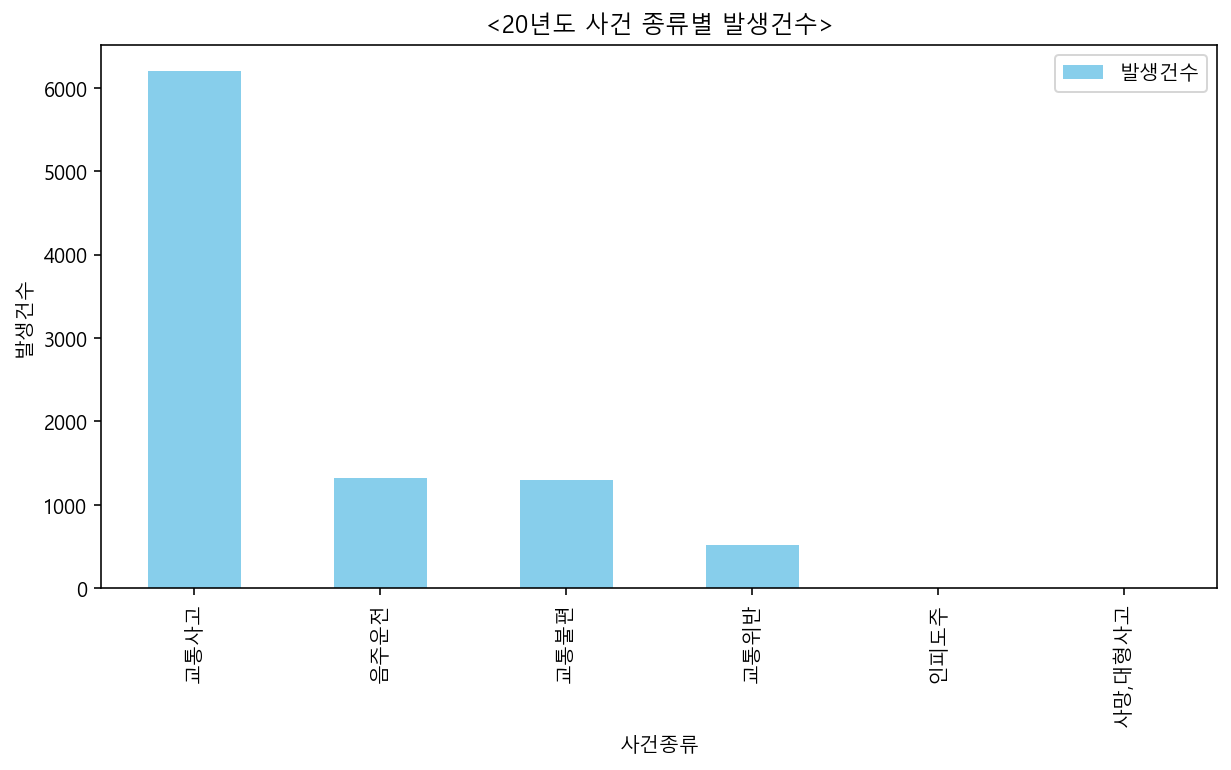

In [10]:
# 20년도 사건 종류별 발생건수

tt20df=tt20df.sort_values("발생건수", ascending=False)

tt20df.plot(kind="bar", figsize=(10,5), color="Skyblue")
plt.xlabel("사건종류")
plt.ylabel("발생건수")
plt.title("<20년도 사건 종류별 발생건수>")

In [11]:
# 21년도 음주운전+교통사고 발생건수
tt21= kp21[(kp21["사건종별코드"]==403) | (kp21["사건종별코드"]== 406) |(kp21["사건종별코드"]== 402)|(kp21["사건종별코드"]== 401)|(kp21["사건종별코드"]== 404)|(kp21["사건종별코드"]== 405)]
print("총 발생건수 :",len(tt21))

총 발생건수 : 278326


In [26]:
# 21년도 각각의 발생건수
print("교통사고 발생건수 :",len(tt21[tt21["사건종별코드"]==401]))
print("교통불편 발생건수 :",len(tt21[tt21["사건종별코드"]==402]))
print("교통위반 발생건수 :",len(tt21[tt21["사건종별코드"]==403]))
print("사망,대형사고 발생건수 :",len(tt21[tt21["사건종별코드"]==404]))
print("인피도주 발생건수 :",len(tt21[tt21["사건종별코드"]==405]))
print("음주운전 발생건수 :",len(tt21[tt21["사건종별코드"]==406]))

교통사고 발생건수 : 164582
교통불편 발생건수 : 37443
교통위반 발생건수 : 24295
사망,대형사고 발생건수 : 16
인피도주 발생건수 : 35
음주운전 발생건수 : 51955


In [27]:
tt21_401=len(tt21[tt21["사건종별코드"]==401])
tt21_402=len(tt21[tt21["사건종별코드"]==402])
tt21_403=len(tt21[tt21["사건종별코드"]==403])
tt21_404=len(tt21[tt21["사건종별코드"]==404])
tt21_405=len(tt21[tt21["사건종별코드"]==405])
tt21_406=len(tt21[tt21["사건종별코드"]==406])

tt21_list=[["교통사고",tt21_401],["교통불편",tt21_402],["교통위반",tt21_403],["사망,대형사고",tt21_404],["인피도주",tt21_405],
        ["음주운전",tt21_406]]
tt21df=pd.DataFrame(tt21_list, columns=["종류","발생건수"])

In [28]:
tt21df=tt21df.set_index("종류").astype(float)
tt21df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 교통사고 to 음주운전
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   발생건수    6 non-null      float64
dtypes: float64(1)
memory usage: 96.0+ bytes


Text(0.5, 1.0, '<21년도 사건 종류별 발생건수>')

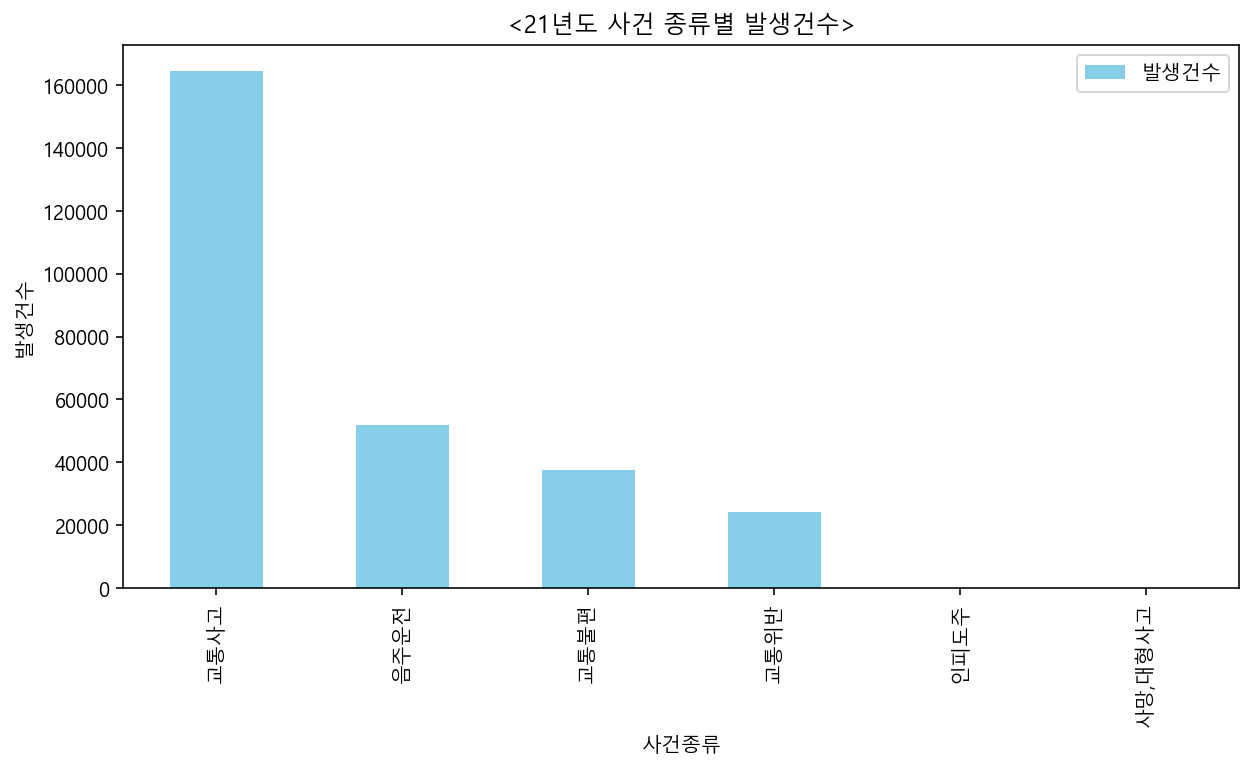

In [37]:
# 20년도 사건 종류별 발생건수

tt21df=tt21df.sort_values("발생건수", ascending=False)

tt21df.plot(kind="bar", figsize=(10,5), color="Skyblue")
plt.xlabel("사건종류")
plt.ylabel("발생건수")
plt.title("<21년도 사건 종류별 발생건수>")

### 접수부서완료일시에서 발생일, 발생시간 추출

In [288]:
tt21

,접수부서코드,접수완료일시,경찰청구분,사건상태코드,사건종별코드,신고성별,발생지점,발생좌표x,발생좌표y,동일사건여부
14,충남청,21/03/07 00:02:48.000000000,19,10,406,1.0,충청남도 천안시 서북구 불당동(불당동) 1625,127.107500,36.811944,NaN
44,충남청,21/03/07 00:12:08.000000000,19,10,403,2.0,충청남도 공주시 우성면 평목리,127.090733,36.453397,NaN
48,충남청,21/03/07 00:13:32.000000000,19,10,406,1.0,충청남도 당진시 송산면 상거리 321-6,126.680044,36.933368,NaN
65,충남청,21/03/07 02:06:29.000000000,19,10,403,1.0,충청남도 천안시 서북구 백석동(백석동) 52-6,127.127337,36.833938,N
70,충남청,21/03/07 02:08:26.000000000,19,10,403,3.0,충청남도 천안시 서북구 백석동(백석동) 325-5,127.118560,36.822827,Y
...,...,...,...,...,...,...,...,...,...,...
2593729,충남청,23/01/18 16:06:19.000000000,19,10,403,3.0,충청남도 천안시 동남구 신부동 (행정:신안동 ) 459-8,127.156334,36.817797,Y
2593799,대전청,23/01/14 17:01:35.000000000,13,10,406,2.0,대전광역시 유성구 지족동 (노은3동 ) 1041,127.304497,36.381533,Y
2593809,충남청,23/01/14 10:43:37.000000000,31,10,403,3.0,세종특별자치시 세종시 나성동 (새롬동 ) 568-3,127.262664,36.478976,Y
2593811,충남청,23/01/18 13:00:37.000000000,19,10,403,1.0,충청남도 당진시 합덕읍 성동리(합덕읍 ) 435-21,126.768976,36.793109,NaN


In [289]:
# datetime을 사용하면 시간이 이상하게 설정되어 직접 슬라이싱
tt21["접수완료연월일"]=tt21["접수완료일시"].apply(lambda x:x[0:-18])

tt21.head(3)

C:\Users\minir\AppData\Local\Temp\ipykernel_24748\1179802541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt21["접수완료연월일"]=tt21["접수완료일시"].apply(lambda x:x[0:-18])


,접수부서코드,접수완료일시,경찰청구분,사건상태코드,사건종별코드,신고성별,발생지점,발생좌표x,발생좌표y,동일사건여부,접수완료연월일
14,충남청,21/03/07 00:02:48.000000000,19,10,406,1.0,충청남도 천안시 서북구 불당동(불당동) 1625,127.107500,36.811944,NaN,21/03/07
44,충남청,21/03/07 00:12:08.000000000,19,10,403,2.0,충청남도 공주시 우성면 평목리,127.090733,36.453397,NaN,21/03/07
48,충남청,21/03/07 00:13:32.000000000,19,10,406,1.0,충청남도 당진시 송산면 상거리 321-6,126.680044,36.933368,NaN,21/03/07


In [290]:
tt21["접수완료시각"]=tt21["접수완료일시"].apply(lambda x:x[8:17])
tt21.head(3)

C:\Users\minir\AppData\Local\Temp\ipykernel_24748\2864951427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt21["접수완료시각"]=tt21["접수완료일시"].apply(lambda x:x[8:17])


,접수부서코드,접수완료일시,경찰청구분,사건상태코드,사건종별코드,신고성별,발생지점,발생좌표x,발생좌표y,동일사건여부,접수완료연월일,접수완료시각
14,충남청,21/03/07 00:02:48.000000000,19,10,406,1.0,충청남도 천안시 서북구 불당동(불당동) 1625,127.107500,36.811944,NaN,21/03/07,00:02:48
44,충남청,21/03/07 00:12:08.000000000,19,10,403,2.0,충청남도 공주시 우성면 평목리,127.090733,36.453397,NaN,21/03/07,00:12:08
48,충남청,21/03/07 00:13:32.000000000,19,10,406,1.0,충청남도 당진시 송산면 상거리 321-6,126.680044,36.933368,NaN,21/03/07,00:13:32


### 대전청, 호남청 범주형 데이터 나누기

In [291]:
tt21.replace({"충남청":1}, inplace=True) # 충남 - 1
tt21.replace({"대전청":2}, inplace=True) # 대전 - 2

C:\Users\minir\AppData\Local\Temp\ipykernel_24748\1997401281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt21.replace({"충남청":1}, inplace=True) # 충남 - 1
C:\Users\minir\AppData\Local\Temp\ipykernel_24748\1997401281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt21.replace({"대전청":2}, inplace=True) # 대전 - 2


In [17]:
tt21.head(50)

,접수부서코드,접수완료일시,경찰청구분,사건상태코드,사건종별코드,신고성별,발생지점,발생좌표x,발생좌표y,동일사건여부,대분류지역,발생시구
14,충남청,21/03/07 00:02:48.000000000,19,10,406,1.0,충청남도 천안시 서북구 불당동(불당동) 1625,127.107500,36.811944,NaN,충청남도,천안시
20,충남청,21/03/07 00:09:04.000000000,19,10,402,1.0,충청남도 천안시 동남구 문화동(문성동) 41-5,127.150988,36.811792,Y,충청남도,천안시
23,대전청,21/03/07 00:07:54.000000000,13,10,401,2.0,대전광역시 서구 괴정동(괴정동) 367-40,127.371854,36.341961,NaN,대전광역시,서구
26,대전청,21/03/07 00:15:27.000000000,13,10,401,1.0,대전광역시 유성구 상대동 471-2,127.339334,36.346899,NaN,대전광역시,유성구
44,충남청,21/03/07 00:12:08.000000000,19,10,403,2.0,충청남도 공주시 우성면 평목리,127.090733,36.453397,NaN,충청남도,공주시
48,충남청,21/03/07 00:13:32.000000000,19,10,406,1.0,충청남도 당진시 송산면 상거리 321-6,126.680044,36.933368,NaN,충청남도,당진시
49,충남청,21/03/07 00:13:58.000000000,19,10,401,1.0,충청남도 천안시 동남구 목천읍 운전리(목천읍) 333-1,127.230796,36.767596,NaN,충청남도,천안시
65,충남청,21/03/07 02:06:29.000000000,19,10,403,1.0,충청남도 천안시 서북구 백석동(백석동) 52-6,127.127337,36.833938,N,충청남도,천안시
70,충남청,21/03/07 02:08:26.000000000,19,10,403,3.0,충청남도 천안시 서북구 백석동(백석동) 325-5,127.118560,36.822827,Y,충청남도,천안시
71,충남청,21/03/07 02:08:19.000000000,19,10,403,1.0,충청남도 천안시 서북구 백석동 656,127.112012,36.822775,Y,충청남도,천안시


### 발생지점에서 시와 구 추출

In [18]:
# 발생지점에서 시 추출
tt21["대분류지역"]=tt21["발생지점"].str.split(" ").str[0]

C:\Users\minir\AppData\Local\Temp\ipykernel_2316\810470993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt21["대분류지역"]=tt21["발생지점"].str.split(" ").str[0]


In [19]:
# 발생지점에서 구 추출
tt21["발생시구"]=tt21["발생지점"].str.split(" ").str[1]

C:\Users\minir\AppData\Local\Temp\ipykernel_2316\1596707597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt21["발생시구"]=tt21["발생지점"].str.split(" ").str[1]


In [20]:
tt21

,접수부서코드,접수완료일시,경찰청구분,사건상태코드,사건종별코드,신고성별,발생지점,발생좌표x,발생좌표y,동일사건여부,대분류지역,발생시구
14,충남청,21/03/07 00:02:48.000000000,19,10,406,1.0,충청남도 천안시 서북구 불당동(불당동) 1625,127.107500,36.811944,NaN,충청남도,천안시
20,충남청,21/03/07 00:09:04.000000000,19,10,402,1.0,충청남도 천안시 동남구 문화동(문성동) 41-5,127.150988,36.811792,Y,충청남도,천안시
23,대전청,21/03/07 00:07:54.000000000,13,10,401,2.0,대전광역시 서구 괴정동(괴정동) 367-40,127.371854,36.341961,NaN,대전광역시,서구
26,대전청,21/03/07 00:15:27.000000000,13,10,401,1.0,대전광역시 유성구 상대동 471-2,127.339334,36.346899,NaN,대전광역시,유성구
44,충남청,21/03/07 00:12:08.000000000,19,10,403,2.0,충청남도 공주시 우성면 평목리,127.090733,36.453397,NaN,충청남도,공주시
...,...,...,...,...,...,...,...,...,...,...,...,...
2593994,대전청,23/01/15 20:01:39.000000000,13,10,401,1.0,대전 서구 괴정동 88-6,127.384284,36.334507,NaN,대전,서구
2594002,충남청,23/01/16 21:26:56.000000000,19,10,401,1.0,충청남도 태안군 근흥면 두야리(근흥면 ) 246-2,126.262393,36.751467,NaN,충청남도,태안군
2594006,충남청,23/01/14 01:02:48.000000000,19,10,403,2.0,충청남도 천안시 동남구 다가동 (일봉동 ) 61-35,127.147678,36.789125,NaN,충청남도,천안시
2594019,대전청,23/01/14 17:35:38.000000000,13,10,401,1.0,대전광역시 대덕구 신탄진동 (행정:신탄진동 ) 129-7,127.433785,36.450725,NaN,대전광역시,대덕구


### 지역분류별 발생건수 그래프

In [297]:
len(tt21[tt21["대분류지역"]=="충청남도"])

47896

In [298]:
len(tt21[tt21["대분류지역"]=="대전광역시"])

20263

In [235]:
len(tt21[tt21["대분류지역"]=="세종특별자치시"])

5123

In [12]:
tt21_cn=len(tt21[tt21["대분류지역"]=="충청남도"])
tt21_dj=len(tt21[tt21["대분류지역"]=="대전광역시"])
tt21_sj=len(tt21[tt21["대분류지역"]=="세종특별자치시"])

tt21_si_list=[["충청남도",tt21_cn],["대전광역시",tt21_dj],["세종시",tt21_sj]]
tt21si=pd.DataFrame(tt21_si_list, columns=["지역 분류","발생건수"])

KeyError: '대분류지역'

In [ ]:
tt21si=tt21si.set_index("지역 분류")
tt21si.sort_values("발생건수", ascending=False)

In [ ]:
tt21si.plot(kind="bar", figsize=(10,10), color="Skyblue")
plt.xlabel("지역 분류", fontsize=12)
plt.ylabel("발생건수", fontsize=15)
plt.title("21년도 사건 발생건수", fontsize=15)
plt.xticks(rotation = 60, fontsize=12)
plt.yticks(fontsize=12)

In [21]:
tt21.value_counts("발생시구")

발생시구
천안시     51437
서구      32323
아산시     23094
유성구     22780
세종시     16303
        ...  
영천시         1
대전면         1
사성마을        1
당진군         1
소정면         1
Length: 206, dtype: int64